======================== Left ============== left_shoulder_angle


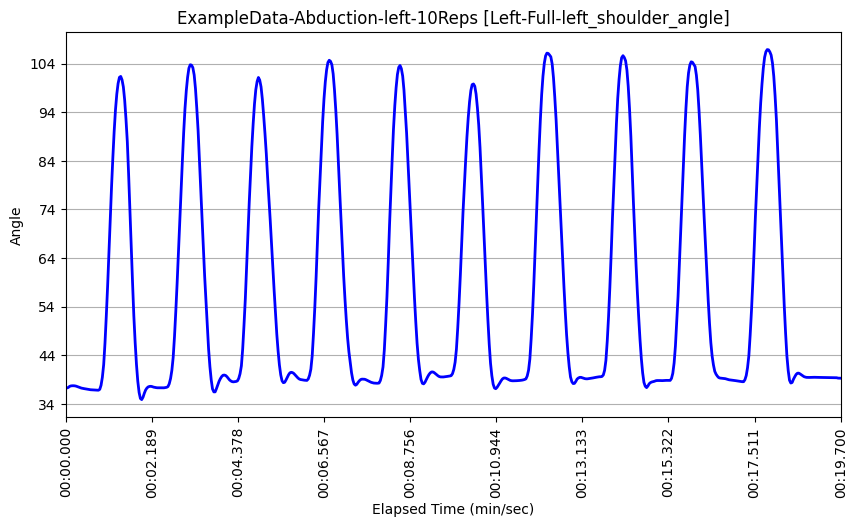

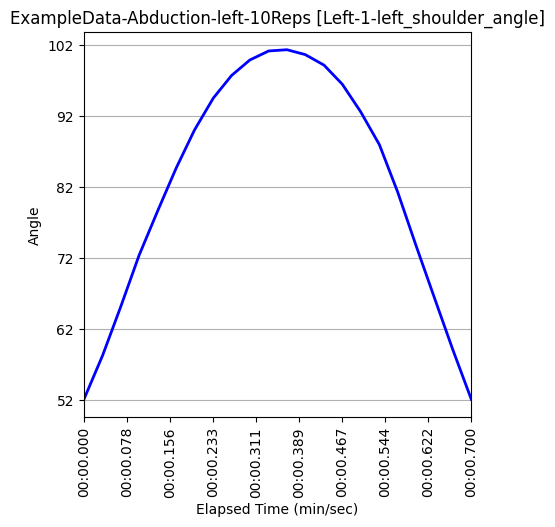

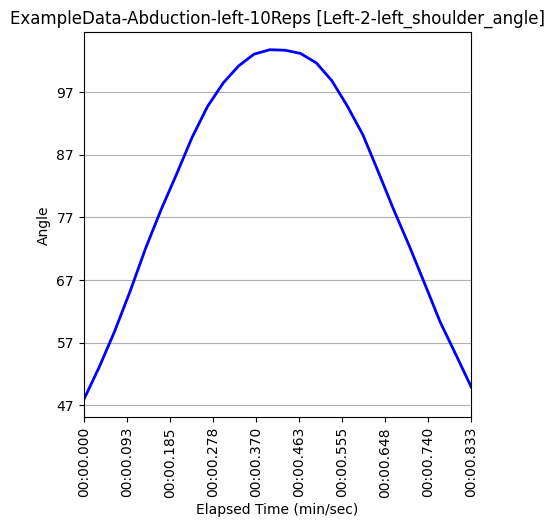

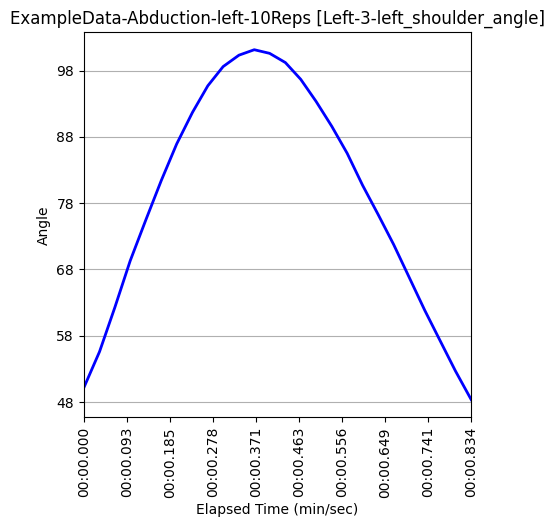

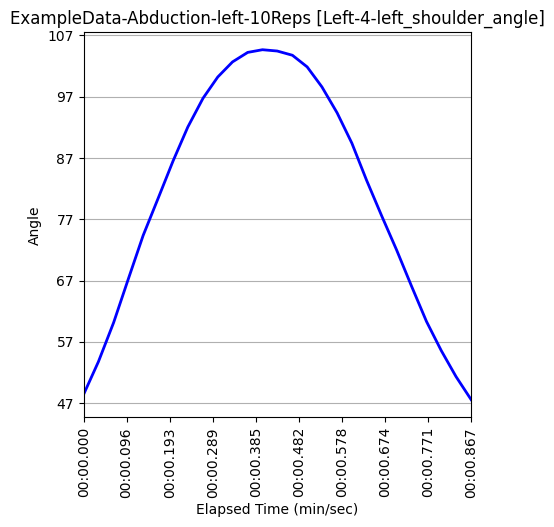

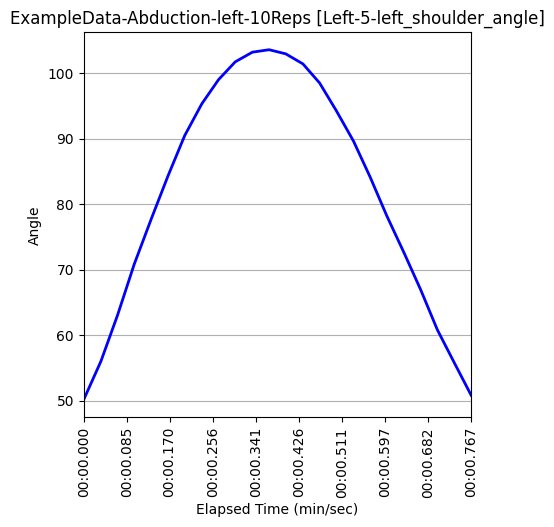

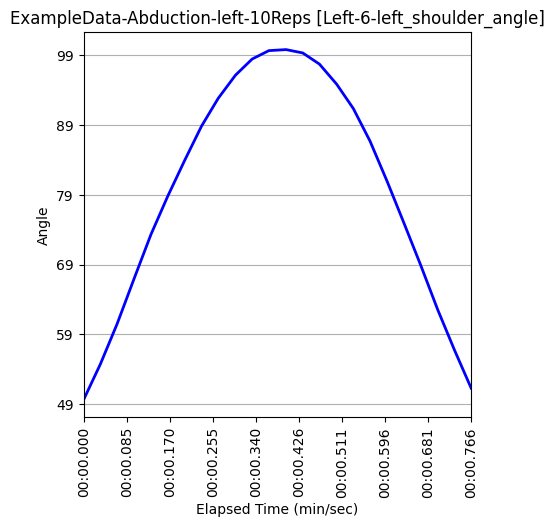

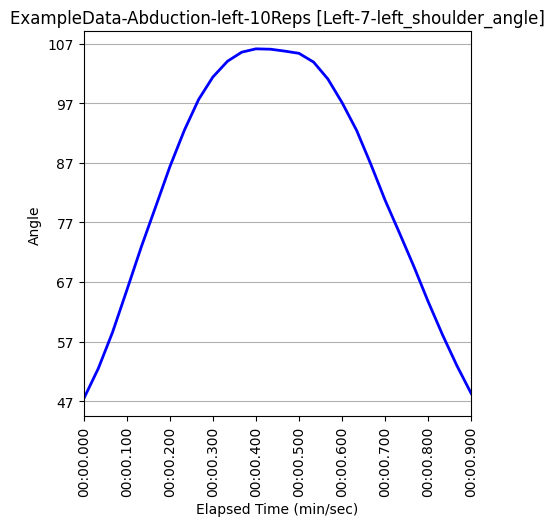

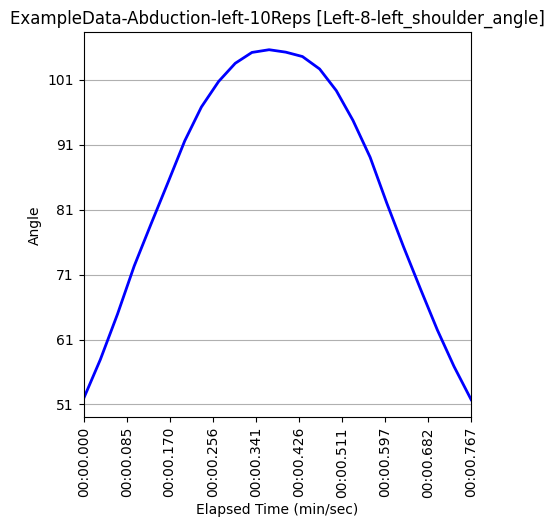

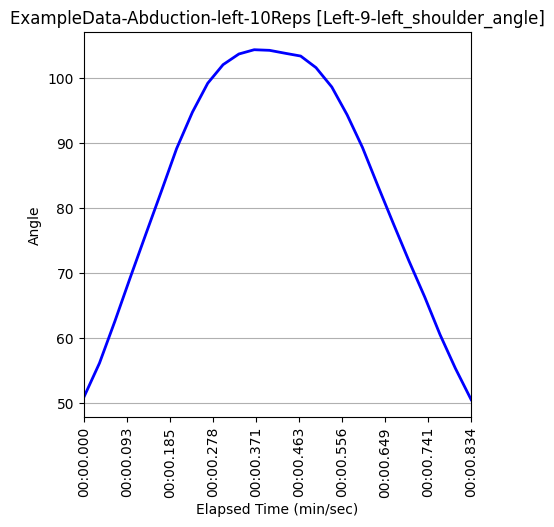

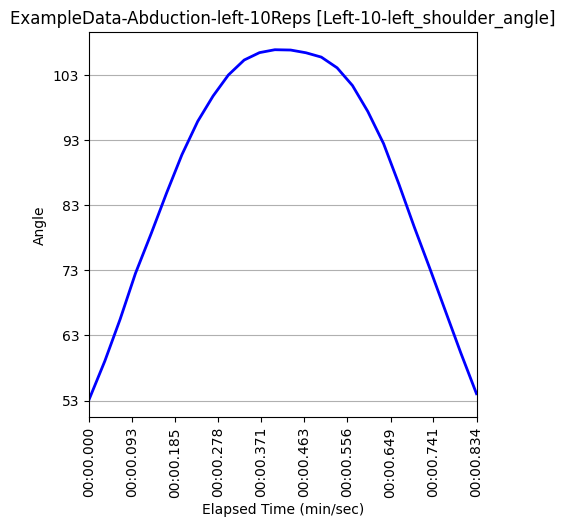

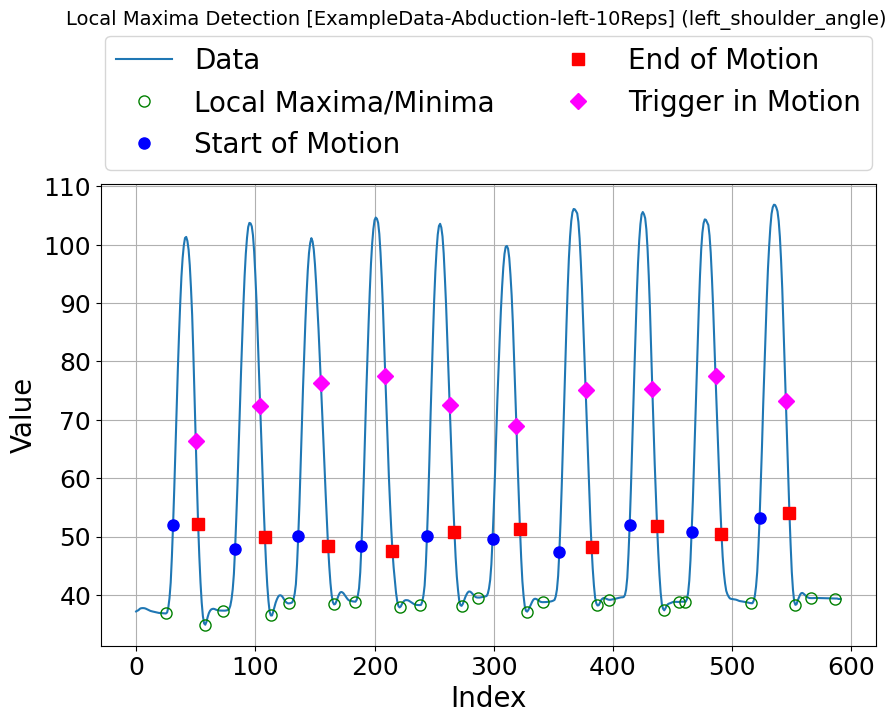

===========================End===============================


ValueError: CSV file 'ExampleData-Abduction-lesft-10Reps.csv' does not contain a valid side. It must include either 'left' or 'right'.

In [ ]:
# =============================================================================
# SETTINGS
# =============================================================================

# Detection and Segmentation settings
exceed_threshold = 10            # Threshold for angle exceeding the current zone to change the state (Raising state & Lowering state)
exceed_frame_required = 3        # Number of frames while exceeding required to change the state

# Local maxima and minima settings
abduction_height = -55           # Negative number only!
shoulder_flexion_height = -20      # Negative number only!
elbow_flexion_height = 105         # Positive number only!

# Folder settings
csv_saved_folder_path = "MovementData"
pose_movement_folder_path = "SegmentedMotion"

# Define angle headers (CSV Headers)
right_elbow_angle_data_header = "right_elbow_angle"
right_shoulder_angle_data_header = "right_shoulder_angle"
right_wrist_angle_data_header = "right_wrist_angle"
left_elbow_angle_data_header = "left_elbow_angle"
left_shoulder_angle_data_header = "left_shoulder_angle"
left_wrist_angle_data_header = "left_wrist_angle"
elapsed_timestamp_data_header = "elapsed_time"

# Put all angle headers in a list for looping if needed
all_angle_headers = [
    right_elbow_angle_data_header,
    right_shoulder_angle_data_header,
    right_wrist_angle_data_header,
    left_elbow_angle_data_header,
    left_shoulder_angle_data_header,
    left_wrist_angle_data_header
]

# Plotting settings
angle_spacing = 10
plot_font_sizes = {
    "title": 14,
    "labels": 20,
    "legend": 20,
    "ticks": 18
}

# =============================================================================
# LIBRARY IMPORTS
# =============================================================================

import os
import math
import shutil
import pandas as pd
import numpy as np
from enum import Enum
from scipy.signal import find_peaks
from matplotlib import pyplot as plt

# =============================================================================
# CLASSES & FUNCTIONS
# =============================================================================

class ArmState(Enum):
    """
    Enumeration for different arm states.
    """
    lowering = 1
    raising = 2
    trigger = 3

class CircularBuffer:
    """
    A simple circular buffer to hold a fixed number of values.
    """
    def __init__(self, size):
        self.size = size
        self.buffer = [None] * size
        self.index = 0
        self.is_full = False

    def add(self, value):
        """
        Add a value to the circular buffer.
        """
        self.buffer[self.index] = value
        self.index = (self.index + 1) % self.size
        if self.index == 0:
            self.is_full = True

    def get(self):
        """
        Retrieve the buffered values in the correct order.
        """
        if self.is_full:
            return self.buffer[self.index:] + self.buffer[:self.index]
        else:
            return [elem for elem in self.buffer if elem is not None]

    def clear(self):
        """
        Clear the circular buffer.
        """
        self.buffer = [None] * self.size
        self.index = 0
        self.is_full = False

def unwrap_angles(angles):
    """
    Unwrap a list of angles.
    
    Parameters:
        angles: List of angle values.
    
    Returns:
        A numpy array of the unwrapped angles.
    """
    angles = np.array(angles, dtype=float)  # Convert to numpy array for easier calculations
    unwrapped_angles = [angles[0]]  # Start with the first angle

    for i in range(1, len(angles)):
        current_angle = angles[i]
        # The previous angle is available as: prev_angle = unwrapped_angles[-1]
        unwrapped_angles.append(current_angle)

    return np.array(unwrapped_angles)

def GetMovementRangeFromAngleData_Narrow(angle_data, elapsed_time_stamp_data):
    """
    Calculate movement ranges using a narrow threshold.
    
    Parameters:
        angle_data: List of angle measurements.
        elapsed_time_stamp_data: Corresponding timestamps.
    
    Returns:
        A dictionary with movement range details.
    """
    currentArmState = ArmState.lowering
    comfortAngle = angle_data[0] + exceed_threshold
    triggerAngle = comfortAngle
    exceedCount = 0

    movementRecorder = {}
    poseMovementRoundIndex = 0
    beforePerformingPoseBuffer = CircularBuffer(5)

    for i in range(len(angle_data)):
        mainAngle = angle_data[i]
        if currentArmState == ArmState.lowering:
            newComfortAngle = mainAngle + exceed_threshold
            if newComfortAngle < comfortAngle:
                comfortAngle = newComfortAngle

            if mainAngle > comfortAngle:
                exceedCount += 1
                if poseMovementRoundIndex not in movementRecorder:
                    movementRecorder[poseMovementRoundIndex] = []
                movementRecorder[poseMovementRoundIndex].append((i, elapsed_time_stamp_data[i], angle_data[i]))
                if exceedCount >= 3:
                    triggerAngle = comfortAngle
                    currentArmState = ArmState.raising
                    exceedCount = 0
            else:
                exceedCount = 0
                beforePerformingPoseBuffer.add((i, elapsed_time_stamp_data[i], angle_data[i]))
                if poseMovementRoundIndex in movementRecorder:
                    movementRecorder.pop(poseMovementRoundIndex)
                    
        elif currentArmState == ArmState.raising:
            newTriggerAngle = mainAngle - exceed_threshold
            movementRecorder[poseMovementRoundIndex].append((i, elapsed_time_stamp_data[i], angle_data[i]))
            if newTriggerAngle > triggerAngle:
                triggerAngle = newTriggerAngle

            if mainAngle < triggerAngle:
                exceedCount += 1
                if exceedCount >= 3:
                    currentArmState = ArmState.trigger
                    comfortAngle = triggerAngle
                    exceedCount = 0

        elif currentArmState == ArmState.trigger:
            # End of a movement range
            movementRecorder[poseMovementRoundIndex].append((i, elapsed_time_stamp_data[i], angle_data[i]))
            beforePerformingPoseBuffer.clear()
            poseMovementRoundIndex += 1
            currentArmState = ArmState.lowering

    # Transform movementRecorder into a structured dictionary
    finalRanges = {}
    for key, vals in movementRecorder.items():
        start_idx = vals[0][0]
        end_idx = vals[-1][0]
        finalRanges[key] = {
            "data": vals,
            "start_index": start_idx,
            "end_index": end_idx
        }

    return finalRanges

def GetMovementRangeFromAngleData_Wide(angle_data, elapsed_time_stamp_data):
    """
    Calculate movement ranges using a wide threshold.
    
    Parameters:
        angle_data: List of angle measurements.
        elapsed_time_stamp_data: Corresponding timestamps.
    
    Returns:
        A dictionary with movement range details.
    """
    exceed_threshold = 10
    currentArmState = ArmState.lowering
    comfortAngle = angle_data[0] - exceed_threshold
    triggerAngle = comfortAngle
    exceedCount = 0

    movementRecorder = {}
    poseMovementRoundIndex = 0
    beforePerformingPoseBuffer = CircularBuffer(5)

    for i in range(len(angle_data)):
        mainAngle = angle_data[i]
        if currentArmState == ArmState.lowering:
            newComfortAngle = mainAngle - exceed_threshold
            if newComfortAngle > comfortAngle:
                comfortAngle = newComfortAngle

            if mainAngle < comfortAngle:
                exceedCount += 1
                if poseMovementRoundIndex not in movementRecorder:
                    movementRecorder[poseMovementRoundIndex] = []
                movementRecorder[poseMovementRoundIndex].append((i, elapsed_time_stamp_data[i], angle_data[i]))
                if exceedCount >= 3:
                    triggerAngle = comfortAngle
                    currentArmState = ArmState.raising
                    exceedCount = 0
            else:
                exceedCount = 0
                beforePerformingPoseBuffer.add((i, elapsed_time_stamp_data[i], angle_data[i]))
                if poseMovementRoundIndex in movementRecorder:
                    movementRecorder.pop(poseMovementRoundIndex)
                    
        elif currentArmState == ArmState.raising:
            newTriggerAngle = mainAngle + exceed_threshold
            movementRecorder[poseMovementRoundIndex].append((i, elapsed_time_stamp_data[i], angle_data[i]))
            if newTriggerAngle < triggerAngle:
                triggerAngle = newTriggerAngle

            if mainAngle > triggerAngle:
                exceedCount += 1
                if exceedCount >= 3:
                    currentArmState = ArmState.trigger
                    comfortAngle = triggerAngle
                    exceedCount = 0

        elif currentArmState == ArmState.trigger:
            # End of a movement range
            movementRecorder[poseMovementRoundIndex].append((i, elapsed_time_stamp_data[i], angle_data[i]))
            beforePerformingPoseBuffer.clear()
            poseMovementRoundIndex += 1
            currentArmState = ArmState.lowering

    # Transform movementRecorder into a structured dictionary
    finalRanges = {}
    for key, vals in movementRecorder.items():
        start_idx = vals[0][0]
        end_idx = vals[-1][0]
        finalRanges[key] = {
            "data": vals,
            "start_index": start_idx,
            "end_index": end_idx
        }

    return finalRanges

def plot_data_with_elapsed_timestamp(
    fileSavePath,
    title,
    timestamps,
    values,
    valueLabel,
    ySpace,
    color='blue',
    comparedValue=None,
    comparedValueLabel='',
    comparedColor='green',
    width=10,
    x_tick_parameter=10
):
    """
    Plot data with elapsed timestamps.
    
    Parameters:
        fileSavePath: Directory to save the plot (if empty, the plot is not saved).
        title: Title of the plot.
        timestamps: List of timestamp values (in seconds).
        values: List of data values to plot.
        valueLabel: Label for the primary data.
        ySpace: Step size for the y-axis ticks.
        color: Color for the primary data plot.
        comparedValue: Optional secondary data to plot.
        comparedValueLabel: Label for the secondary data.
        comparedColor: Color for the secondary data plot.
        width: Width of the plot (figure size).
        x_tick_parameter: Parameter for x-axis tick spacing.
    """
    # Convert timestamps from seconds to milliseconds for labeling
    x_values = [t * 1000 for t in timestamps]
    fig, ax = plt.subplots(figsize=(width, 5))

    y_values = values
    min_y_value = min(y_values)
    max_y_value = max(y_values)

    if x_tick_parameter != 0:
        x_min = min(x_values)
        x_max = max(x_values)
        if x_tick_parameter > 0:
            if x_tick_parameter == 1:
                x_ticks = [round(x_min)]
            else:
                interval = (x_max - x_min) / (x_tick_parameter - 1)
                x_ticks = [round(x_min + i * interval) for i in range(x_tick_parameter)]
        else:
            seconds_per_tick = abs(x_tick_parameter)
            ms_per_tick = seconds_per_tick * 1000
            start = round(x_min)
            if start < x_min:
                start = math.ceil(x_min)
            x_ticks = list(range(start, round(x_max) + 1, ms_per_tick))
            if not x_ticks:
                x_ticks = [round(x_min), round(x_max)]

        x_tick_labels = [
            f"{int(ts/1000//60):02}:{int((ts/1000)%60):02}.{int(ts%1000):03}"
            for ts in x_ticks
        ]

        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_tick_labels, rotation=90)
        plt.xlabel('Elapsed Time (min/sec)')
    else:
        plt.xlabel('Elapsed Time (min/sec)')

    plt.yticks(range(int(min_y_value), int(max_y_value) + ySpace, ySpace))
    plt.ylabel(valueLabel if comparedValueLabel is None else "Angle")

    plt.plot(x_values, y_values, marker='', color=color, linewidth=2, label=valueLabel)
    plt.xlim(x_values[0], x_values[-1])

    if comparedValue is not None:
        y2_values = comparedValue
        plt.plot(x_values, y2_values, marker='', color=comparedColor, linewidth=2, zorder=1, label=comparedValueLabel)
        plt.legend()

    plt.title(title)
    plt.grid(axis='y')
    if fileSavePath != "":
        plt.savefig(fileSavePath + title + ".png", bbox_inches='tight')
    plt.show()

def find_closest_and_greater_index(main_number, number_list):
    """
    Find the smallest number in number_list that is greater than main_number.
    
    Parameters:
        main_number: The reference number.
        number_list: A list of numbers.
    
    Returns:
        The closest number greater than main_number, or None if not found.
    """
    closest_index = None
    min_difference = float('inf')

    for number_index in number_list:
        if number_index > main_number:
            difference = number_index - main_number
            if difference < min_difference:
                min_difference = difference
                closest_index = number_index

    return closest_index

def delete_files_in_path(path):
    """
    Delete all files in the given directory.
    
    Parameters:
        path: Path to the directory.
    """
    files = os.listdir(path)
    for file in files:
        file_path = os.path.join(path, file)
        if os.path.isfile(file_path):
            os.remove(file_path)

def find_closest_index(data, target_value):
    """
    Find the index of the element in data closest to target_value.
    
    Parameters:
        data: An iterable of numeric values.
        target_value: The value to compare.
    
    Returns:
        The index corresponding to the closest value.
    """
    absolute_differences = np.abs(data - target_value)
    closest_index = np.argmin(absolute_differences)
    closest_value = data.index[closest_index]
    return closest_value

def find_closest_index_non_CSV(data, target_value):
    """
    Find the element in data closest to target_value.
    
    Parameters:
        data: A list of numeric values.
        target_value: The value to compare.
    
    Returns:
        The closest value from the list.
    """
    absolute_differences = np.abs(data - target_value)
    closest_index = np.argmin(absolute_differences)
    closest_value = data[closest_index]
    return closest_value

# =============================================================================
# MAIN PROCESSING CODE
# =============================================================================

# Recreate the pose movement folder (delete files and then recreate the folder)
delete_files_in_path(pose_movement_folder_path)
os.makedirs(pose_movement_folder_path, exist_ok=True)

pd.options.display.max_rows = 4000

files = os.listdir(csv_saved_folder_path)
csv_files = [file for file in files if file.endswith('.csv')]

# Define required keywords for posture and side
required_postures = ['Abduction', 'ShoulderFlexion', 'ElbowFlexion']
required_sides = ['left', 'right']

for csv_file in csv_files:
    # Check that the CSV filename contains one of the posture names
    if not any(posture in csv_file for posture in required_postures):
        raise ValueError(
            f"CSV file '{csv_file}' does not contain a valid posture name. It must include one of: {', '.join(required_postures)}"
        )
    
    # Check that the CSV filename contains one of the side names (case insensitive)
    if not ('left' in csv_file.lower() or 'right' in csv_file.lower()):
        raise ValueError(
            f"CSV file '{csv_file}' does not contain a valid side. It must include either 'left' or 'right'."
        )
    
    file_name_without_extension = os.path.splitext(csv_file)[0]
    csv_file_path = os.path.join(csv_saved_folder_path, csv_file)
    original_df = pd.read_csv(csv_file_path)

    # Condition: Use shoulder angles if file name contains "ShoulderFlexion" or "Abduction", else use elbow angles.
    if "ShoulderFlexion" in csv_file or "Abduction" in csv_file:
        if "right" in csv_file.lower():
            angle_headers_to_use = [right_shoulder_angle_data_header]
        else:
            angle_headers_to_use = [left_shoulder_angle_data_header]
    else:
        if "right" in csv_file.lower():
            angle_headers_to_use = [right_elbow_angle_data_header]
        else:
            angle_headers_to_use = [left_elbow_angle_data_header]

    # Create a folder to store results for this file
    movement_range_result_saved_directory = os.path.join(pose_movement_folder_path, file_name_without_extension)
    if os.path.exists(movement_range_result_saved_directory):
        shutil.rmtree(movement_range_result_saved_directory)
    os.makedirs(movement_range_result_saved_directory, exist_ok=True)

    for current_header_selecting in angle_headers_to_use:
        # Skip if the current angle header is not in the DataFrame
        if current_header_selecting not in original_df.columns:
            continue

        angle_data = original_df[current_header_selecting]
        side = "Right" if "right" in current_header_selecting.lower() else "Left"
        angle_subfolder_path = os.path.join(movement_range_result_saved_directory, current_header_selecting)
        os.makedirs(angle_subfolder_path, exist_ok=True)

        # Get movement range data dictionary based on file name conditions
        if "ShoulderFlexion" in csv_file or "Abduction" in csv_file:
            movement_range_data_dict = GetMovementRangeFromAngleData_Narrow(angle_data, original_df[elapsed_timestamp_data_header])
        else:
            movement_range_data_dict = GetMovementRangeFromAngleData_Wide(angle_data, original_df[elapsed_timestamp_data_header])

        print(f"======================== {side} ============== {current_header_selecting}")

        # Find local extrema based on posture type in the file name
        if "Abduction" in csv_file:
            maxima_indices, _ = find_peaks(-angle_data, height=abduction_height)  # Local minima
        elif "ShoulderFlexion" in csv_file:
            maxima_indices, _ = find_peaks(-angle_data, height=shoulder_flexion_height)  # Local minima
        elif "ElbowFlexion" in csv_file:
            maxima_indices, _ = find_peaks(angle_data, height=elbow_flexion_height)   # Local maxima
        else:
            raise ValueError("Unrecognized posture type in file name.")

        # Plot full data for this angle
        plot_data_with_elapsed_timestamp(
            fileSavePath=angle_subfolder_path + "/",
            title=f'{file_name_without_extension} [{side}-Full-{current_header_selecting}]',
            timestamps=original_df[elapsed_timestamp_data_header],
            values=angle_data,
            valueLabel=f'{side.capitalize()} Angle',
            ySpace=angle_spacing,
            color='blue'
        )

        motion_start_point_recorder = []
        motion_trigger_point_recorder = []
        motion_end_point_recorder = []

        # Process each movement range using start/end indices
        for movement_index, movement_info in movement_range_data_dict.items():
            vals = movement_info["data"]
            start_index = movement_info["start_index"]
            # Use the last index in the movement data as the trigger point
            trigger_point_index = vals[-1][0]

            motion_start_point_recorder.append(start_index)
            motion_trigger_point_recorder.append(trigger_point_index)

            # Find a new end index from local extrema
            new_end_moveRange_index_from_maxima = find_closest_and_greater_index(trigger_point_index, maxima_indices)
            if new_end_moveRange_index_from_maxima is None:
                new_end_moveRange_index_from_maxima = angle_data.index[-1]

            data_between_trigger_point_and_maxima = original_df.loc[trigger_point_index:new_end_moveRange_index_from_maxima]
            motion_start_point_data = original_df.loc[start_index]

            closet_index = find_closest_index(
                data_between_trigger_point_and_maxima[current_header_selecting],
                motion_start_point_data[current_header_selecting]
            )
            motion_end_point_recorder.append(closet_index)

            # Extract movement range data from the DataFrame
            movement_range_df = original_df.loc[start_index:closet_index]
            movement_range_df.reset_index(drop=True, inplace=True)

            iteration_count = movement_index + 1
            side_file_name = f'{file_name_without_extension} [{side}-{str(iteration_count)}-{current_header_selecting}]'
            csv_saved_path = os.path.join(angle_subfolder_path, side_file_name + '.csv')
            movement_range_df.to_csv(csv_saved_path, index=False)

            # Plot the extracted movement range
            min_timestamp = movement_range_df[elapsed_timestamp_data_header].min()
            elapsed_time = [t - min_timestamp for t in movement_range_df[elapsed_timestamp_data_header]]
            plot_width = len(vals) / len(angle_data) * 10
            plot_data_with_elapsed_timestamp(
                fileSavePath=angle_subfolder_path + "/",
                title=side_file_name,
                timestamps=elapsed_time,
                values=movement_range_df[current_header_selecting],
                valueLabel=f'{side.capitalize()} Angle',
                ySpace=angle_spacing,
                color='blue',
                width=5
            )

        # After processing all movements for this angle, plot local extrema and key points
        plt.figure(figsize=(10, 6))
        plt.suptitle(
            f"Local Maxima Detection [{file_name_without_extension}] ({current_header_selecting})",
            fontsize=plot_font_sizes["title"],
            y=1.17
        )
        plt.plot(angle_data, label="Data")
        local_maxima = angle_data[maxima_indices]
        plt.plot(maxima_indices, local_maxima, 'go', label="Local Maxima/Minima", markersize=8, markerfacecolor='none', markeredgecolor='g')

        start_angles = [original_df.loc[idx, current_header_selecting] for idx in motion_start_point_recorder]
        plt.plot(
            motion_start_point_recorder, start_angles,
            marker='o', label="Start of Motion", markersize=8, color='blue', linestyle='none', linewidth=1
        )

        end_angles = [original_df.loc[idx, current_header_selecting] for idx in motion_end_point_recorder]
        plt.plot(
            motion_end_point_recorder, end_angles,
            marker='s', label="End of Motion", markersize=8, color='red', linestyle='none', linewidth=1
        )

        trigger_angles = [original_df.loc[idx, current_header_selecting] for idx in motion_trigger_point_recorder]
        plt.plot(
            motion_trigger_point_recorder, trigger_angles,
            marker='D', label="Trigger in Motion", markersize=8, color='magenta', linestyle='none', linewidth=1
        )

        plt.xlabel("Index", fontsize=plot_font_sizes["labels"])
        plt.ylabel("Value", fontsize=plot_font_sizes["labels"])
        plt.legend(fontsize=plot_font_sizes["legend"], loc='lower center', bbox_to_anchor=(0.5, 1), ncol=2)
        plt.xticks(fontsize=plot_font_sizes["ticks"])
        plt.yticks(fontsize=plot_font_sizes["ticks"])
        plt.grid(True)
        plt.savefig(os.path.join(angle_subfolder_path, f"{file_name_without_extension}_{current_header_selecting}.jpg"), bbox_inches='tight')
        plt.show()

    print("===========================End===============================")
